# 11 - Free exchange

Last time we looked at deep strong coupling. We saw that the interaction term could give us creation and destruction of many bosons.

Can we make of of this energy?

The first part of this answer is to see whether the boson energy can be effectively exchanged with the TLS when it's got its own energy

In [4]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.formatter.useoffset'] = False
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import Image
from IPython.display import Video

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *

# The helper file below brings functions created in previous tutorials
from libs.helper_11_tutorial import *

## 11.1 - Recap

For the last few tutorials, we've been spending a lot of time building up capabilities for studying many TLS.

For this tutorial, we've going to return to a single TLS coupled to a quantised boson field. We've previously called this the spin-boson model, but it's also called the Rabi model. The Hamiltonian is given by:

$$H =  \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)(\sigma_+ + \sigma_-)$$

where $\Delta E$ as the transition energy of the TLS, $\hbar\omega$ is the energy of a single boson and $U$ as the strength of the interaction of the TLS with the boson field. The $\sigma$ operators are the [Pauli spin matrices](https://ocw.mit.edu/courses/5-61-physical-chemistry-fall-2007/3b1fb40c61e7f939861b190bedbc57a7_lecture24.pdf) that act on the TLS, where $\sigma_+$ and $\sigma_-$ act as raising and lowering operators. The $a^{\dagger}$, $a$ are the field creation and annihilation operators respectively.

In [5]:
H_latex = "$H = (\Delta E / 2) \sigma_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )\sigma_x$"

It's worth noting that we're using the Pauli spin matrices as a mathematical tool to describe two levels. Just keep in mind that we're not really talking about spin angular momentum here.

Let's reuse the `make_operators` function from [tutorial 10](https://github.com/project-ida/two-state-quantum-systems/blob/master/10-deep-strong-coupling.ipynb) to conveniently create the operators needed for the Hamiltonian.

In [3]:
def make_operators(max_bosons, parity=0, offset=0):
    
    a  = tensor(destroy(max_bosons+1, offset), qeye(2))     # tensorised boson destruction operator
    ad  = tensor(create(max_bosons+1, offset), qeye(2))     # tensorised boson creation operator
    sx = tensor(qeye(max_bosons+1), sigmax())               # tensorised sigma_x operator (= sigma+ + sigma-)
    sz = tensor(qeye(max_bosons+1),sigmaz())                # tensorised sigma_z operator
    number = tensor(num(max_bosons+1, offset), qeye(2))     # tensorised number number operator 𝑎†𝑎
    
    two_state     =  1/2*sz                         # two state system energy operator   𝜎𝑧/2
    bosons       =  (number + 0.5)                  # boson energy operator              𝑎†𝑎+1/2
    interaction  = (ad + a) * sx                    # interaction energy operator        (𝑎†+𝑎)𝜎𝑥  
    
    P = sz*(1j*np.pi*a.dag()*a).expm()              # parity operator 
    P = Qobj(P.full().real, dims=P.dims)            # makes sure no small imaginary parts that can happen for larger number of bosons 
    
    # map from QuTiP number states to |n,±> states
    possible_ns = range(offset, offset + max_bosons + 1)
    possible_ms = ["+","-"]
    nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state   = two_state.extract_states(p)
        bosons      = bosons.extract_states(p)
        number      = number.extract_states(p)
        interaction = interaction.extract_states(p)
        nm_list     = [nm_list[i] for i in p]
    
    
    return two_state, bosons, interaction, number, nm_list

Let's consider the case (as we've done many times throughout this tutorial series) of two coupled pendulums with frequencies $\omega_1$ and $\omega_2$. The coupling can be described in terms of a frequency $\omega_{\rm coupling}$ (imagine a spring connecting the two pendulums) and dissipation can be described by a rate $\gamma_{\rm diss}$.

The different coupling regimes are determined by how large $\omega_{\rm coupling}$ is compared to $\omega_1$, $\omega_2$ and $\gamma_{\rm diss}$. The naming conventions used in the [quantum optics literature](https://www.nature.com/articles/s42254-018-0006-2) are going to be useful for us. They describe the coupling as:

- Weak -  $\omega_{\rm coupling} \ll \gamma_{\rm diss} \ll \omega_1,\omega_2$
- Strong - $\gamma_{\rm diss} \ll \omega_{\rm coupling} \ll \omega_1,\omega_2$
- Ultra strong - $\gamma_{\rm diss} \ll \omega_{\rm coupling} \sim 0.1\times  \omega_1,\omega_2$
- Deep strong - $\gamma_{\rm diss} \ll \omega_1,\omega_2 \lesssim \omega_{\rm coupling}$

### Weak coupling

When the coupling is weak, there are very small changes in the natural frequencies of the system as compared to the uncoupled case and energy does not move back and forwards between the pendulums because the large dissipation removes energy from the system before exchange can happen.

**INSERT VIDEO**

### Strong coupling

When the coupling is strong, the dissipation is small enough to allow energy to be slowly [exchanged between the two pendulums](https://www.youtube.com/watch?v=CjJVBvDNxcE&t=57s). The motion is characterised by individual swings whose amplitude $\theta$ gradually undulates on a timescale related to the small coupling. This exchange happens most effectively when the pendulums have the same length, so that their natural frequencies are the same. When this is not the case (e.g. $\omega_2>\omega_1$), then only a small fraction ($\omega_{\rm coupling}^2/\omega_2^2$) of the amplitude of one pendulum moves across to the other.
> Aside: The small fraction expression can be calculated by assuming that the second "faster" pendulum moves while the first "slower" one is static. The second pendulum then experiences a constant force pulling it out of equilibrium towards the first pendulum. Force balance for the second pendulum is reached when $\theta_2 = \theta_1\omega_{\rm coupling}^2/\omega_2^2 $.

**INSERT VIDEO**

### Ultra strong coupling

When the coupling is ultra strong, energy exchange happens on the time scale of a single swing of one of the pendulums.  The two natural natural frequencies - when both pendulums move in the same and in opposite directions to one another - can be noticeably discerned. The coupling is getting strong enough so that more energy can be exchanged between pendulums of different lengths. This exact boundary for this regime is somewhat artificial - there is nothing particularly special about the value $0.1 \omega_{\rm 1}, \omega_2$. This value was first used as part of the quantum optics literature.

**INSERT VIDEO**

### Deep strong coupling

When the coupling is deep strong, the coupling begins to dominate over everything else.  Energy transfer between two pendulums of any length is not only possible but it happens so fast that it's almost instantaneous compared to pendulum periods. When one pendulum is pulled out of equilibrium the other "immediately" follows and so the pendulums start acting as a single rigid body. Large amounts of force, and hence energy are required to displace only one of the pendulums.

**INSERT VIDEO**

### From classical to quantum 

A full account of the correspondence between quantum system and classical oscillators is well documented in [Briggs et.al](http://dx.doi.org/10.1103/PhysRevA.85.052111). It's helpful to give a simplified summary here. 

In the quantum case, each state $|\psi_i \rangle$ is like a pendulum whose frequency is determined by the state's energy $E_i$ and whose amplitude is determined by the state's quantum amplitude $\langle\psi_i|\psi\rangle$ (and hence the state's occupation probability $|\langle\psi_i|\psi\rangle|^2$). When the quantum pendulums are coupled together, instead of thinking about energy being exchanged between the pendulums, we should think in terms of exchange of occupation probability. In other words, the system makes a transition from one state to another when the pendulum amplitude moves from one pendulum to another.
> It should be noted that when the coupling becomes ultra-strong, the equivalent classical pendulum frequency departs from $E_i/\hbar$ significantly. This means that although there is a formal mathematical equivalence between the the quantum and and classical systems, the classical mapping becomes more difficult to interpret the stronger the coupling gets.

The Rabi probability oscillations that we've observed throughout this tutorial series are a signal that we've been working in the "strong coupling" regime. Indeed, we've not included any quantum dissipation such as dephasing or decoherence in our models ($\gamma_{\rm diss}=0$) and so $\gamma_{\rm diss} \ll \omega_{\rm coupling} \ll \omega_1,\omega_2$ has always been satisfied.

Now we're going to consider the deep strong coupling regime of the Rabi model. Will our quantum system exhibit a kind of "rigid body motion" in this regime? Or will it look totally alien to us? Let's find out.

## 10.1 Vacuum field deep strong coupling ($n=0$)

Much like the classical pendulum, the dynamics of the the Rabi model depend on the relative sizes of the different frequencies/energies in the system, which are represented by $\Delta E, \hbar\omega, U$ in the Hamilonian:

$$H = \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)(\sigma_+ + \sigma_-)$$

The deep strong coupling regime, as first explored by [Casanova et al. in 2010](http://dx.doi.org/10.1103/PhysRevLett.105.263603), is then defined as:

$$
\Delta E , \hbar \omega \lesssim U
$$

Last tutorial we had $\Delta E = 0$. Now we're going to let $\Delta E \neq 0$.


Before we start simulating, let's see if we can predict what will happen.

Ideally, we'd like to appeal to our classical pendulum picture, but this is challenging because the number of states (aka quantum pendulums) that are involved. Each state of the system is described by combining the two states of the TLS (denoted $\pm$) with the boson states (denoted by the number of quanta $n$). There are an infinite number of such states $|n, \pm\rangle$.

Thnking about infinity is hard, so let's begin with thinking about two states and see how far we get.

Let's imagine we start the system in the ground state of the TLS and in vacuum - in other words $\psi_0 = |0,-\rangle$. Because of parity conservation, we know that this state is only coupled to states that simultaneously flip the TLS and shift the boson number by one. The only state that satisfies this is $|1,+\rangle$. The two states have different energies/frequencies from one another and so the pendulum set-up looks like this.

![](./img/pendulums-dsc-01.png)

If the pendulums were weakly coupled, then we'd not expect the second pendulum to move much at all because it's natural frequency is very different from the first. For pendulums that are coupled in a deep strong way, we've already seen that one displaced pendulum will pull the other one out of equilibrium even when the natural frequencies are highly mismatched. 

What we can predict for the quantum system is that the vacuum state won't be stable. We're not going to be able to initialise the vacuum state and have it just sit there - other states (with potentially very different energies) are likely to get occupied.

Our prediction seems to violate energy conservation so we should be a bit skeptical. Let's do the actual quantum calculations.

### Two coupled states

Using casanova's parameters in our units gives:

In [293]:
# Recall that in our units hbar=1 and omega = 1
DeltaE = 36
omega = 1
U = 3

In order to limit the infinite number of states to the two we are interested in ($|0,-\rangle$ and $|1,+\rangle$), we need to restrict the max bosons to 1:

In [294]:
max_bosons = 1

Now we make the necessary operators for the simulation. We'll work with a single (negative) parity because parity is a conserved quantity so there is no use in simulating both.

In [295]:
two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=max_bosons, parity=-1)

Next we create the bra and ket labels used for plotting later.

In [296]:
bra_labels, ket_labels = make_braket_labels(nm_list)

Our initial TLS ground state in vaccuum is the first state in the list:

In [297]:
nm_list[0]

(0, '-')

In [298]:
psi0 = basis(len(nm_list), 0)

Now for the Hamiltonian.

In [299]:
H =  DeltaE*two_state + omega*bosons + U*interaction

In [300]:
times = np.linspace(0.0, 1*(2*np.pi/omega), 2000)

As we've done before, we can extract just the probabilities for states instead of the wavefunction by using projection opperators.

In [301]:
projection_operators = [basis(len(nm_list), i).proj() for i in range(len(nm_list))]

We'll also extract expectation values for some of the Hamiltonian operators.

In [302]:
result = sesolve(H, psi0, times, e_ops = projection_operators + [number, U*interaction, omega*bosons, DeltaE*two_state])

probs = result.expect[:-4]      # Remove the last 3 expectations to get the state probabilities
expected = result.expect[-4:]   # The last 3 expectations are the number, interaction and field energies

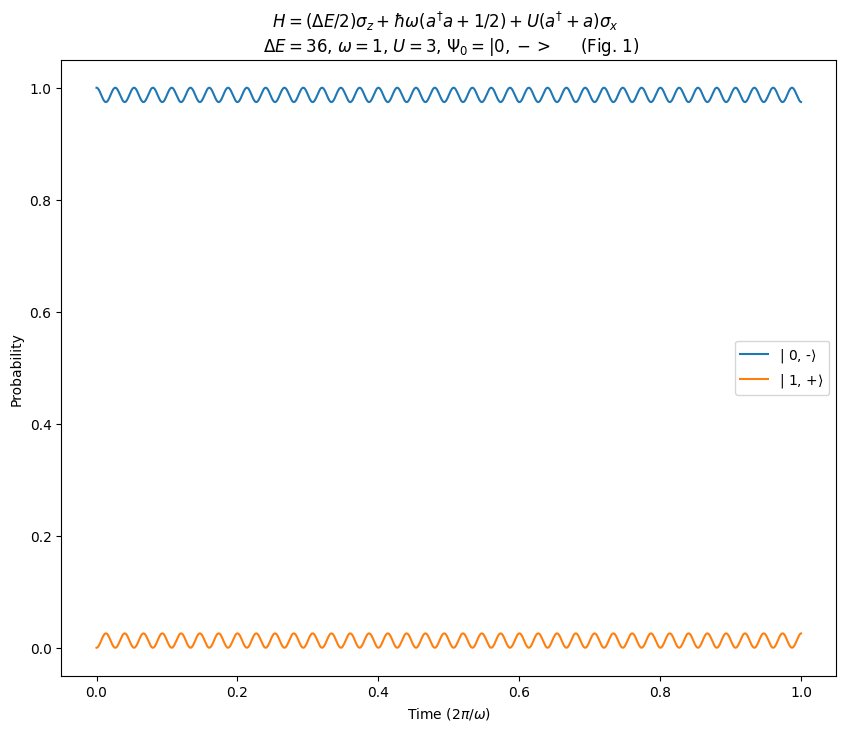

In [303]:
plot_sim(times/(2*np.pi/omega), probs ,labels=ket_labels)
plt.title(f" {H_latex}   \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|0,->$     (Fig. 1)");
plt.xlabel("Time ($2\pi/\omega$)");

Nothing happens because the coupling is not deep strong

### Arbitrary number of coupled states

What happens when we remove the artificial restriction of having only two states? How does our picture change?

A significant change is that the coupling between the states is not constant - it depends on how many field quanta $n$ we have. This is because of how the field operators work:

$$
\begin{aligned}
a^{\dagger} |n,\pm\rangle &= \sqrt{n+1}|n+1,\pm\rangle \\
a |n,\pm\rangle &= \sqrt{n}|n-1,\pm\rangle \\
a^{\dagger}a |n,\pm\rangle &= n|n,\pm\rangle
\end{aligned}
$$

Far from being constant, the coupling scales as $\sim 2U\sqrt{n}$. Our picture is therefore going to look something like:

![](./img/pendulums-dsc-02.png)

In general, as we increase the number of quantum states, the simple pendulum picture starts to lose exact equivalence. Notwistanding this, the pictures can still help guide our intuition.

From the picture above, we might expect that several states are going to become occupied. This would mean that several bosons get created as the amplitude of the initial $|0,-\rangle$ pendulum moves across from left to right. There will likely be a limit to how far the amplitude spreads because of the increasing mismatch in pendulum frequencies. It's hard to predict exactly how far the spread will go because although the mismatch increases, so too does the coupling 🤷‍♂️.

Let's simulate and find out if our intuition is right.

We're just going to repeat the analysis above, but instead of having `max_bosons=1` we'll allow `max_bosons=40`.

In [307]:
max_bosons = 40

In [308]:
two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=max_bosons, parity=-1)

In [309]:
bra_labels, ket_labels = make_braket_labels(nm_list)

In [310]:
nm_list[0]

(0, '-')

In [311]:
psi0 = basis(len(nm_list), 0)

In [312]:
H =  DeltaE*two_state + omega*bosons + U*interaction

In [313]:
times = np.linspace(0.0, 10*(2*np.pi/omega), 2000)

In [314]:
projection_operators = [basis(len(nm_list), i).proj() for i in range(len(nm_list))]

In [315]:
result = sesolve(H, psi0, times, e_ops = projection_operators + [number, U*interaction, omega*bosons, DeltaE*two_state])

probs = result.expect[:-4]      # Remove the last 3 expectations to get the state probabilities
expected = result.expect[-4:]   # The last 3 expectations are the number, interaction and field energies

We'll only visualise the first 20 states so that we can still fit all the states in the legend.

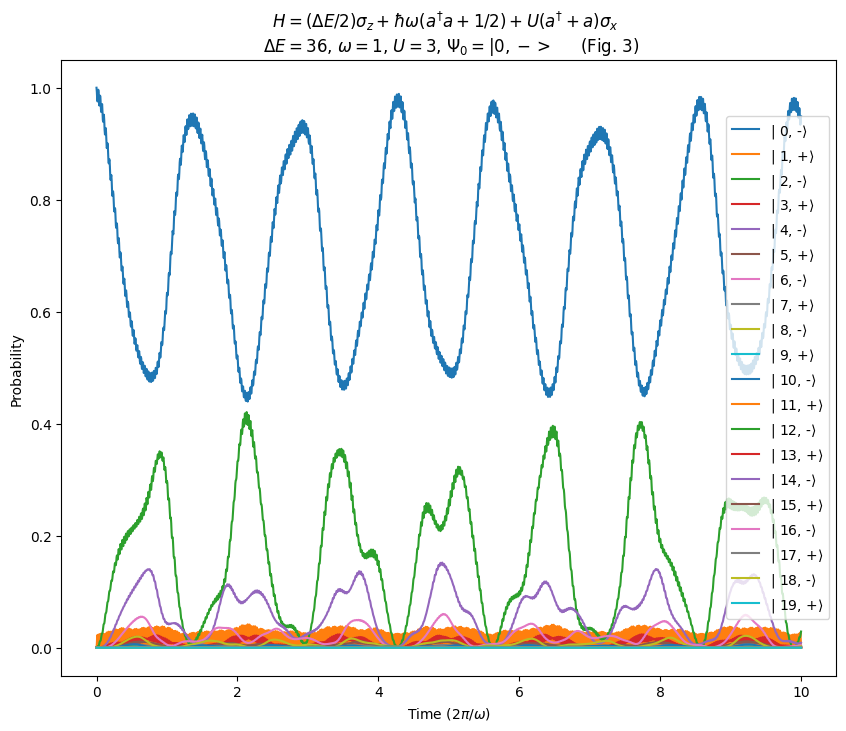

In [316]:
plot_sim(times/(2*np.pi/omega), probs[:20] ,labels=ket_labels)
plt.title(f" {H_latex}   \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|0,->$     (Fig. 3)");
plt.xlabel("Time ($2\pi/\omega$)");

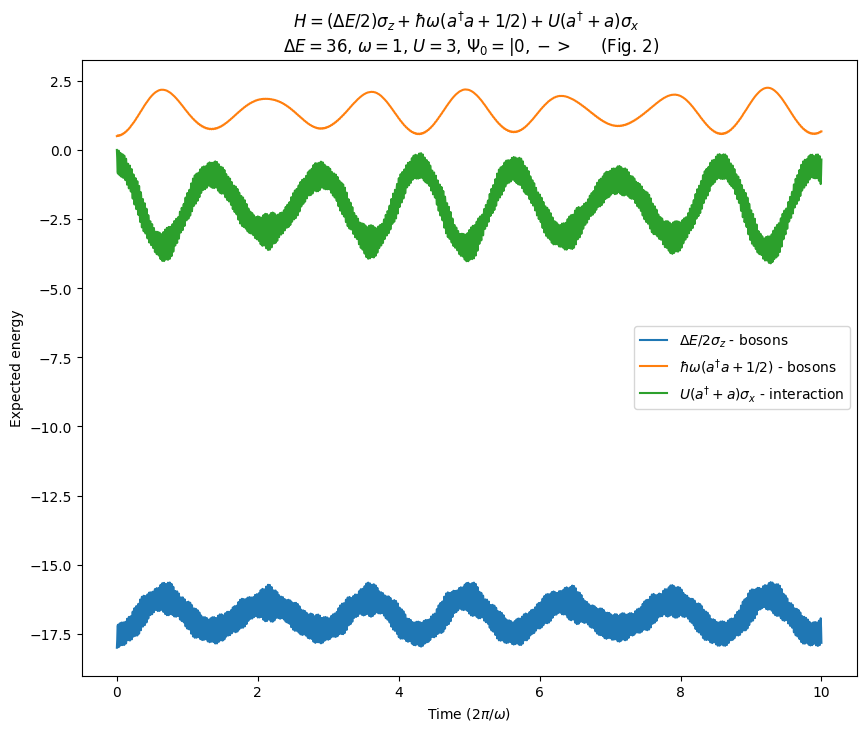

In [317]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi/omega), expected[3], label="$\Delta E/2 \sigma_z$ - bosons")
plt.plot(times/(2*np.pi/omega), expected[2], label="$\hbar\omega(a^{{\dagger}}a +1/2)$ - bosons")
plt.plot(times/(2*np.pi/omega), expected[1], label="$U( a^{{\dagger}} + a )\sigma_x$ - interaction")
plt.ylabel("Expected energy")
plt.xlabel("Time ($2\pi/\omega$)")
plt.title(f" {H_latex}   \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|0,->$     (Fig. 2)");
plt.legend(loc='right');
plt.show();

Fig. 3 shows that we've got many more states occupied that just $|1,+\rangle$. Let's take a look at the expectation value of the boson number to see how many we've got.

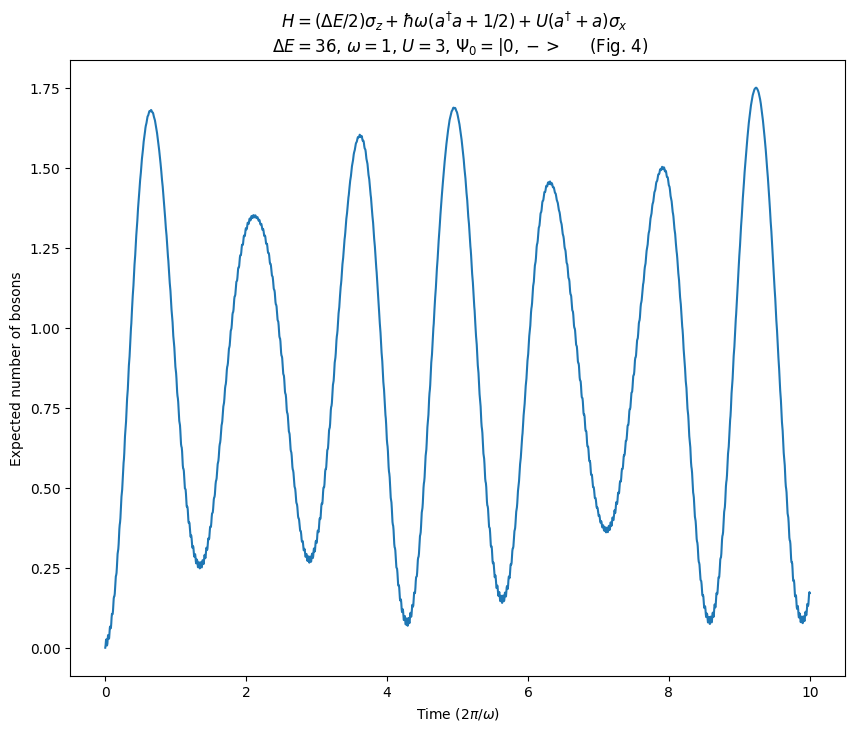

In [318]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi/omega), expected[0])
plt.ylabel("Expected number of bosons")
plt.xlabel("Time ($2\pi/\omega$)")
plt.title(f" {H_latex}   \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|0,->$     (Fig. 4)");
plt.show();

We've still got instability of the vacuum state. how?

INDIRECT COUPLING A BIT LIKE EXCITATINO TRANSFER WHEN WE BROKE DESTRUCTIVE INTERFERENCE 

$$
\frac{U^2}{\Delta E} > \hbar \omega
$$

$$
\frac{U}{\hbar\omega} > \sqrt{\frac{\Delta E}{\hbar\omega}}
$$

So the coupling doesn't have to be as strong as we might initially have expected for intereting things to happen.

This condition also crops up in related area of phase transitions in the Rabi model as $\Delta E \rightarrow \infty$.

Fig. 4 suggests that the system is periodically creating and destroying 16 bosons. It can be difficult to wrap your head around the dynamics here so it's helpful to introduce a few more ways to visualise the dynamics.

Instead of splitting out the state probabilities $P$ into individual lines $P_n(t)$ as in Fig. 3, we can combine them into a single probability function that depends on time and number of bosons $P(t,n)$. We can then make a heat map to visualise the dynamics as seen below.

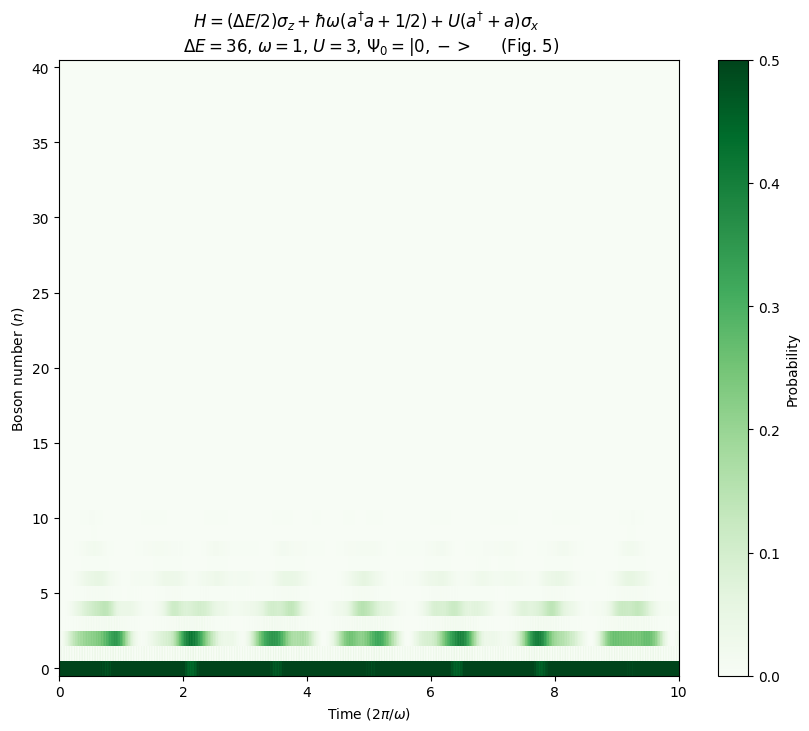

In [292]:
plt.figure(figsize=(10,8))
plt.pcolormesh(times/(2*np.pi/omega), np.arange(max_bosons+1), probs, shading='auto', cmap='Greens', vmax=0.5)
plt.colorbar(label="Probability")
plt.xlabel("Time ($2\pi/\omega$)")
plt.ylabel("Boson number ($n$)")
plt.title(f" {H_latex}   \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|0,->$     (Fig. 5)");
# plt.ylim(top=25)

plt.show()

The colour gradients in Fig. 5 gives us more information than just the expected boson number in Fig. 4. Looking a the first cycle ($t\le 1$), the dark green around $t=0$ represents large amounts of probability in a smaller number of states - in other words we have small uncertainty in the state of the system. As time goes on, the green gets fainter as the probability is spread out over a larger number of states - with maximum spreading at $t=0.5$.

We can gain more insight by making an animation of QuTiP's [`plot_fock_distribution`](https://qutip.readthedocs.io/en/qutip-5.1.x/guide/guide-visualization.html#fock-basis-probability-distribution) that creates a bar chart of the state probabilities. This will work for visualising boson number states because the states for a single parity don't contain duplicate boson numbers, e.g. for negative parity the states are enumerated like:

In [238]:
nm_list

[(0, '-'),
 (1, '+'),
 (2, '-'),
 (3, '+'),
 (4, '-'),
 (5, '+'),
 (6, '-'),
 (7, '+'),
 (8, '-'),
 (9, '+'),
 (10, '-'),
 (11, '+'),
 (12, '-'),
 (13, '+'),
 (14, '-'),
 (15, '+'),
 (16, '-'),
 (17, '+'),
 (18, '-'),
 (19, '+'),
 (20, '-'),
 (21, '+'),
 (22, '-'),
 (23, '+'),
 (24, '-'),
 (25, '+'),
 (26, '-'),
 (27, '+'),
 (28, '-'),
 (29, '+'),
 (30, '-'),
 (31, '+'),
 (32, '-'),
 (33, '+'),
 (34, '-'),
 (35, '+'),
 (36, '-'),
 (37, '+'),
 (38, '-'),
 (39, '+'),
 (40, '-')]

This means that the index of each state then corresponds to the number of bosons in that state.

[`plot_fock_distribution`](https://qutip.readthedocs.io/en/qutip-5.1.x/guide/guide-visualization.html#fock-basis-probability-distribution) requires wavefunction input instead of probabilities, so we need to re-run the simulation without the expectation operators.

In [57]:
result = sesolve(H, psi0, times)

Now we'll write a function to animate over time:

In [58]:
def animate_fock(states, times, omega=1, xlabel="State number", title="", frame_interval=10, xlim=[None,None], ylim=[0,1]):
    num_levels = states[0].shape[0]  # Number of Fock states (Hilbert space dimension)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 5),constrained_layout=True)
    
    # Initial plot
    plot_fock_distribution(states[0], ax=ax)  # Plot first frame
    ax.set_title(f"{title} \n $t/(2\pi/\omega)$ = {times[0] / (2 * np.pi/omega):0.2f} ")
    ax.set_xlim(xlim[0],xlim[0])
    ax.set_ylim(ylim[0],ylim[1])
    
    # Function to update each frame
    def update(frame):
        ax.clear()  # Clear the previous plot
        plot_fock_distribution(states[frame], ax=ax)  # Redraw the Fock distribution
        
        # Update title with time
        ax.set_title(f"{title} \n $t/(2\pi/\omega)$ = {times[frame] / (2 * np.pi/omega):0.2f} ")
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Probability")
        ax.set_xlim(xlim[0],xlim[1])
        ax.set_ylim(ylim[0],ylim[1])
    
        return ax
    
    # Set up animation
    frame_indices = np.arange(0, len(times), frame_interval)
    ani = animation.FuncAnimation(fig, update, frames=frame_indices, interval=50, blit=False)
    
    # Suppress static plot
    plt.close(fig)

    return ani

In [59]:
ani=animate_fock(result.states, times, xlabel="Boson number state",
                title=f"{H_latex}    (Fig. 6) \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|0,->$")

In [60]:
%%time
# Save the animation as a file
ani.save('./img/ani-fock-freex-01.mp4', writer='ffmpeg', fps=30)

CPU times: user 52.7 s, sys: 1.69 s, total: 54.4 s
Wall time: 18.5 s


In [61]:
Video("./img/ani-fock-freex-01.mp4") 

Fig. 6 shows that the system appears to exhibit a wavepacket like motion where the initially peaked wavefunction $|0,-\rangle$ rapidly (less than a wave period) transforms into a Guassian wavepacket that proceeds to move and the reflect off an invisible boundary as the bosons are periodically created and  destroyed. The invisible reflective boundary is a result of the limitations of the amount of energy debt that can be taken on by the interaction term. 

### Energy exchange

There is a limit to the amount of energy debt that the interaction terms can take on. This limitation arises because the energy cost of the bosons grows like $n$ whereas the interaction terms grows more slowly like $\sqrt{n}$. At some level of bosons, the energy required to make an extra boson outstrips the interaction's ability to provide. Another way of saying this is that field energy scales like the square of the field strength whereas interactions scale linearly with the field strength.

From these ideas, we can calculate how much $n$ can change ($\delta n$) by equating the energy change in the field to the energy change in the interaction.  We can do this because there is no change in the overall Hamiltonian since energy is conserved. Let's see this explicitly by creating an "initial" Hamiltonian ($H_1$) and a "final" Hamiltonian ($H_2$):

$$
H_1 \sim \hbar \omega \left(n + \tfrac{1}{2}\right) + 2U\sqrt{n}
$$

$$
H_2 \sim \hbar \omega \left(n + \delta n + \tfrac{1}{2}\right) + 2U\sqrt{n + \delta n}
$$

Now applying energy conservation $\Delta H = H_2 - H_1 = 0$ gives us:
$$
\hbar \omega \delta n + 2U\sqrt{n + \delta n} - 2U\sqrt{n} = 0
$$

$$
\hbar \omega \delta n = 2U\sqrt{n} - 2U\sqrt{n + \delta n}
$$

Let $g = \frac{U}{\hbar \omega}$ so that we can solve the equation for $\delta n$ a little more cleanly:

$$
\left(\frac{\delta n}{g} - 2\sqrt{n}\right)^2 = 4(n + \delta n)
$$

$$
\left(\frac{\delta n}{g}\right)^2 - 4\frac{\delta n}{g} \sqrt{n} + 4n - 4n - 4\delta n = 0
$$

$$
\frac{\delta n}{g} \left(\frac{\delta n}{g} - 4\sqrt{n} - 4g\right) = 0
$$

$$
\delta n = 4g^2 + 4g\sqrt{n}
$$

$$
\boxed{\delta n = 4\left(\frac{U}{\hbar \omega}\right)^2 + 4\frac{U}{\hbar \omega} \sqrt{n}}
$$


If we plug in our numbers, $U=2$, $n=0$, we get:

In [1235]:
4*U**2

16

We get exactly the max number of bosons that we saw in our simulations in Fig. 4 🙌 . This gives us some confidence that we understand what's driving the dynamics of the deep strong coupling regime beyond appealing to analogies with pendulums.

We can further test this understanding by comparing the $\delta n$ formula for the vacuum and non-vacuum cases. While the vacuum case is limited by the coupling constant $U$, for a highly excited field where $n \gg 0 $, it appears that we can spontaneously create/destroy a great many more bosons ~$\sqrt{n}$. 

We'll test this prediction shortly, but before we do, we need to talka bit more about the nature of the traveling guassians.

### Coherent states

This Guassian wavepacket we saw in Fig. 6 have a name - [coherent states](https://en.wikipedia.org/wiki/Coherent_state#Coherent_states_in_quantum_optics). Unlike a [Fock state](https://en.wikipedia.org/wiki/Fock_state) (denoted $|n\rangle$) a coherent state has no fixed number of bosons. A coherent state is not however a simple superposition of several Fock states - it's a special state that "minimises uncertainty". 

Minimizing uncertainly was a task Schrödinger set out to achieve in order to find quantum states that we as close to being classical as one could get. For a quantised field (i.e. a harmonic oscillator), these special states turned out to be eigenstates of the annihilation operator:

$$a |\alpha \rangle = |\alpha|e^{i\theta} |\alpha \rangle$$

Conceptually, for a field state to be unchanged by the annihilation operator (i.e. for it to be an eigenstate), it must be the case that observing the field through absorbing photons does not change the state. This is very much a classical view - that we can observe the system without changing it.

When you crank through the details, coherent states end up looking like:

$$
|\alpha \rangle =e^{-{|\alpha |^{2} \over 2}}\sum _{n=0}^{\infty }{\alpha ^{n} \over {\sqrt {n!}}}|n\rangle
$$

when represented in terms of boson number states (i.e. Fock states). As you can see, it's not a simple superposition but an infinite superposition.

An important characteristic of coherent states is that they have identical average and variance in the boson number. Specifically:

$$
\langle n \rangle = |\alpha|^2
$$

$$
(\Delta n)^2 = |\alpha|^2
$$

This is what we observe in Fig. 6 - as the peak (the average) of the wave packet moves, it's width increases.

In the extreme case when $\alpha=0$, we have a coherent state with zero variance and zero mean - that sounds a lot like our initial fock state $|-, 0\rangle$. We can confirm this using QuTiPs in-built function `coherent(number_of_fock_states, alpha)`

In [60]:
coherent(max_bosons+1, 0)

Quantum object: dims = [[41], [1]], shape = (41, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

Looks a lot like the $|-, 0\rangle$ state. We can double check by confirming equality of the two states.

In [61]:
coherent(max_bosons+1, 0) == basis(len(nm_list), 0)

True

It seems like coherent states are a more natural type of state to work with than simple Fock states when working in the deep strong coupling regime.  We'll therefore start to use them in addition to Fock states from now on.

## 10.4 Strong field deep strong coupling ($n\gg 0$)

The deep strong coupling regime as defined earlier, $\Delta E, \hbar\omega \ll U$, has received a lot of attention because it's [only recently](https://pubs.acs.org/doi/10.1021/acs.nanolett.7b03103) become experimentally available.

However, it's notable that the instability of the vacuum state is not unique to the vacuum. As the field becomes more excited (increasing $n$), the coupling increases as $2U\sqrt{n}$ and so even for a very small $U$ there is a point at which:

$$
\Delta E , \hbar \omega \lesssim 2U\sqrt{n}
$$

This regime is not typically given a name in the literature so we'll call it **strong field deep strong coupling**. At this level of bosons, we can once again expect that our initial state will not be stable and we'll get the creation/destruction of bosons just as in the vacuum case.

We can however expect a difference from the vacuum case because there will be boson states below as well as above our starting state. There should be a degree of symmetry between the above and below states.

Let's see.

### Symmetric dynamics

We'll test our ideas by using a small coupling that's typical of simulations we've done in previous tutorials, $U=0.01$. Remember we're still working with a degenerate TLS so that $\Delta E=0$.

In [82]:
# Recall that in our units hbar=1 and omega = 1
DeltaE = 0
omega = 1
U = 0.01

Our challenge is to see if, with $U=0.01$, we can produce a similar level of creation and destruction of bosons as we did when $U=2$. In other words, can we get a $\delta n \approx 16$? How excited does the field need to be for this?

To figure that out, we need to equate the $\delta n$ for $n=0$ with the $\delta n$ for $n \gg 0$ from our formula:

$$
\delta n = 4\left(\frac{U}{\hbar \omega}\right)^2 + 4\frac{U}{\hbar \omega} \sqrt{n}
$$

In other words:

$$
\begin{aligned}
4\frac{U_{\rm small}}{\hbar\omega}\sqrt{n} &= 4\left(\frac{U_{\rm vacuum}}{\hbar\omega}\right)^2 \\
n &= \left(\frac{U_{\rm vacuum}}{U_{\rm small}}\right)^2\left(\frac{U_{\rm vacuum}}{\hbar\omega}\right)^2 \\
n &= \left(\frac{2}{0.01}\right)^2 \times 4\\
n &= 160,000
\end{aligned}
$$

Simulating the system for values of $n$ ranging from 0 to 160,000 is extremely computationally demanding. The Hamiltonian is a matrix whose size scales with the square of the total number of states and so we'd need to store $10^{11}$ numbers 😱. Aside from the computational issues, we don't even need to store all this information because if we start out system off at $n=160,000$ then we expect that we'll only be exploring $\pm 16$ around this $n$.

Luckily for us, QuTiP has a built in way to `offset` the field operators so that we only use states that we need. For example, the QuTiP `num`, operator takes a second argument that offsets the boson number by a desired amount:

In [83]:
num(10,100) # diagonal matrix whose entries are the number of bosons in that state

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 101.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 102.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 103.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 104.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 105.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 106.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 107.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 108.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 109.]]

QuTiP offers similar offsets for the `create` and `destroy` operators.

So, all we have to do is modify our `make_operators` function to use this offset and then shift the labelling of the number states and away we go 🚀.

In [84]:
def make_operators(max_bosons, parity=0, offset=0):
    
    a  = tensor(destroy(max_bosons+1, offset), qeye(2))     # tensorised boson destruction operator
    ad  = tensor(create(max_bosons+1, offset), qeye(2))     # tensorised boson creation operator
    sx = tensor(qeye(max_bosons+1), sigmax())               # tensorised sigma_x operator (= sigma+ + sigma-)
    sz = tensor(qeye(max_bosons+1),sigmaz())                # tensorised sigma_z operator
    number = tensor(num(max_bosons+1, offset), qeye(2))     # tensorised number number operator 𝑎†𝑎
    
    two_state     =  1/2*sz                         # two state system energy operator   𝜎𝑧/2
    bosons       =  (number + 0.5)                  # boson energy operator              𝑎†𝑎+1/2
    interaction  = (ad + a) * sx                    # interaction energy operator        (𝑎†+𝑎)𝜎𝑥  
    
    P = sz*(1j*np.pi*a.dag()*a).expm()              # parity operator 
    P = Qobj(P.full().real, dims=P.dims)            # makes sure no small imaginary parts that can happen for larger number of bosons 
    
    # map from QuTiP number states to |n,±> states
    possible_ns = range(offset, offset + max_bosons + 1)
    possible_ms = ["+","-"]
    nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state   = two_state.extract_states(p)
        bosons      = bosons.extract_states(p)
        number      = number.extract_states(p)
        interaction = interaction.extract_states(p)
        nm_list     = [nm_list[i] for i in p]
    
    
    return two_state, bosons, interaction, number, nm_list

We're ready to simulate. Let's set-up the system with the ability to simulate 40 bosons above and below our initial level of $n=160,000$.

In [85]:
n_inital = 160000
max_bosons = 80
n_min = int(n_inital - max_bosons/2)

In [86]:
two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=max_bosons, parity=-1, offset=n_min)
bra_labels, ket_labels = make_braket_labels(nm_list)

The initial state with $n=160,000$ state should be in the middle of the our list of states.

In [87]:
nm_list[int(max_bosons/2)]

(160000, '-')

In [88]:
psi0 = basis(len(nm_list), int(max_bosons/2))

Now we repeat simulate just as before.

In [89]:
H =  DeltaE*two_state + omega*bosons + U*interaction

In [90]:
times = np.linspace(0.0, 3.5*(2*np.pi/omega), 28000)

In [76]:
projection_operators = [basis(len(nm_list), i) * basis(len(nm_list), i).dag() for i in range(len(nm_list))]

In [77]:
result = sesolve(H, psi0, times, e_ops = projection_operators)

probs = result.expect

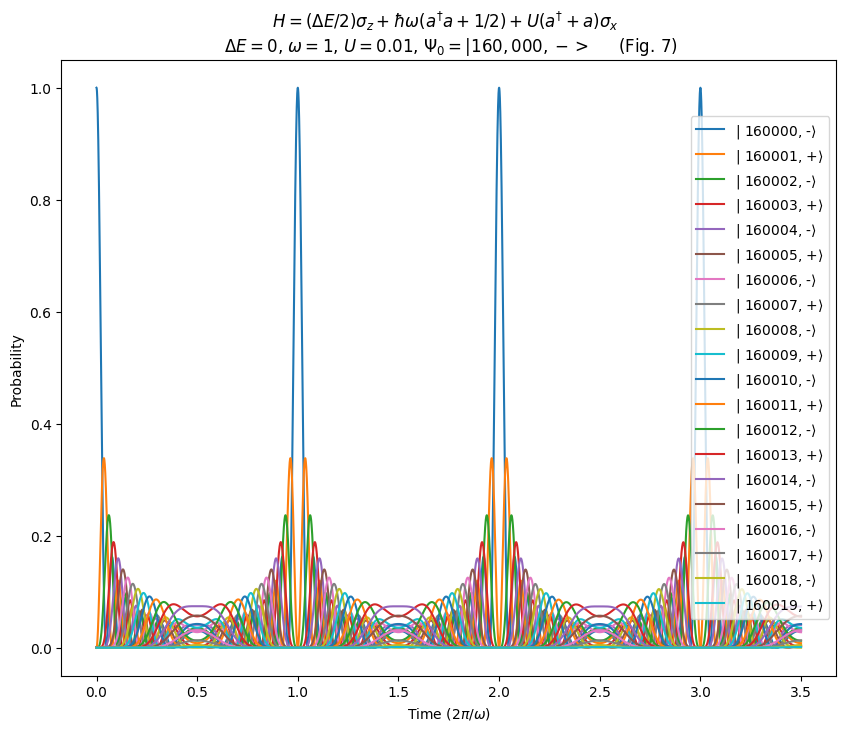

In [78]:
plot_sim(times/(2*np.pi/omega), probs[40:60] ,labels=ket_labels[40:60])
plt.title(f" {H_latex}   \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|160,000,->$     (Fig. 7)");
plt.xlabel("Time ($2\pi/\omega$)");

Fig. 7 shows us similar behaviour to the vacuum case in Fig. 3 😎 - great start! You might notice that we're only plotting the states with higher boson number - the situation is almost identical if we look at the lower states as we see below.

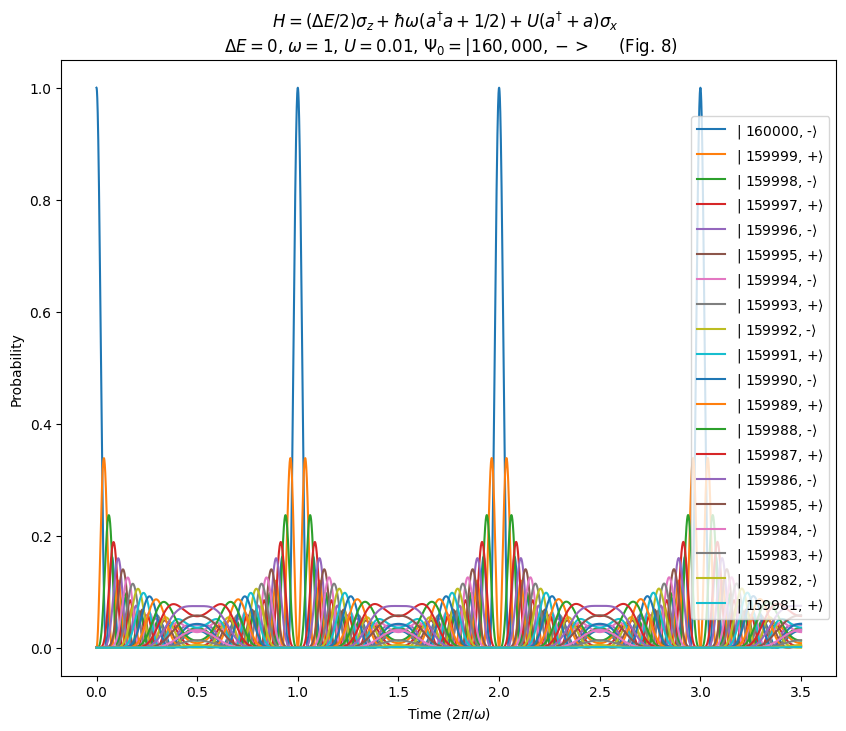

In [79]:
plot_sim(times/(2*np.pi/omega), probs[40:20:-1] ,labels=ket_labels[40:20:-1])
plt.title(f" {H_latex}   \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|160,000,->$     (Fig. 8)");
plt.xlabel("Time ($2\pi/\omega$)");

Because of the almost perfect symmetry between increasing and decreasing boson number, there's no significant change in  $\langle n \rangle$. There is however a significant spread away from the initial $n=160,000$ as we can see below.

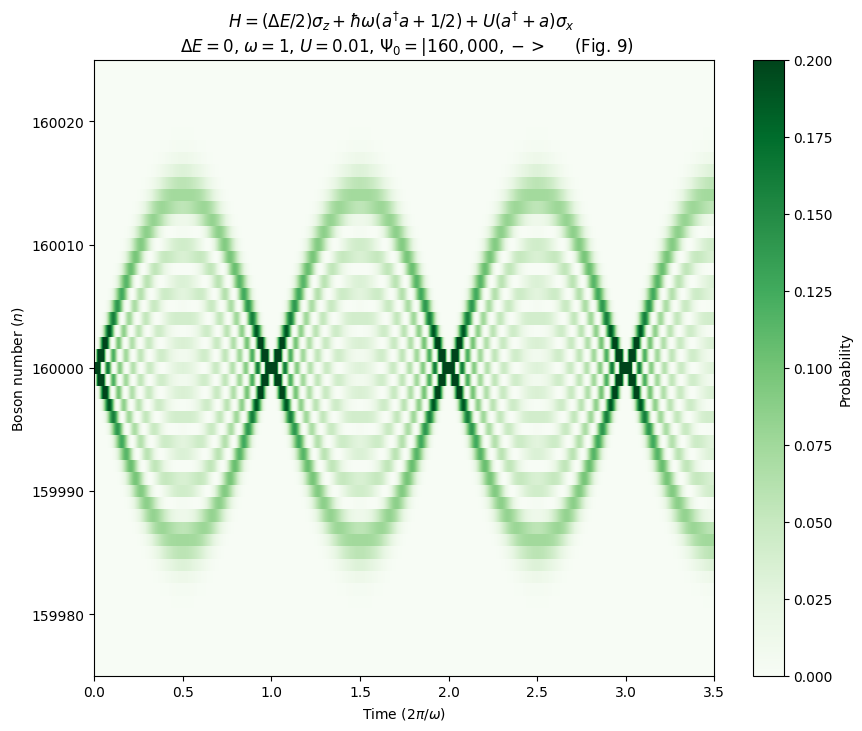

In [80]:
plt.figure(figsize=(10,8))
plt.pcolormesh(times/(2*np.pi/omega), np.arange(n_min,n_min+max_bosons+1), probs, shading='auto', cmap='Greens', vmax=0.2)
plt.colorbar(label="Probability")
plt.xlabel("Time ($2\pi/\omega$)")
plt.ylabel("Boson number ($n$)")
plt.xticks()
plt.title(f" {H_latex}   \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|160,000,->$     (Fig. 9)");
plt.ylim(top=n_inital+25,bottom=n_inital-25)
plt.show()

The extent of the deviations in Fig. 9 are aligned with the expected $\delta n \approx 16$ that we aimed for 🙌. So even with a small coupling constant, we can still see deep strong like effects as long as the field is sufficiently excited.

### Asymmetric dynamics

You might have noticed that below Fig. 8, we talked about "almost perfect symmetry". It's actually not perfect because boson creation goes like $\sqrt{n+1}$ whereas destruction like $\sqrt{n}$. This means there is a slight preference for nature to create rather than to destroy. This is actually a fundamental part of why lasers work - once you have some photons created they stimulate the release of more in an exponential manner.
> Lasers also require a so called "population inversion" where there are more excited TLS compared to ground state ones. We are not modelling that scenario in this tutorial

The reason we didn't see a more noticeable asymmetry in Fig. 9 is because:
- The larger $n$ the smaller the differece bweeen $\sqrt{n}$ and $\sqrt{n+1}$
- We started the system in a Fock state instead of a coherent one.

Creating coherent states at $n=160,000$ is not possible using QuTiP even when using an offset. We're therefore going to reduce the bosons to a more more reasonable level.

We'll pick a `max_bosons = 800` so that we're able to simulate up to $n \sim 400$ or so without running into boundary effects.

Let's see if a coherent states will break the symmetry that we saw in Fig. 9.

In [319]:
max_bosons = 800

We'll return to Casanova's numbers

In [661]:
# Recall that in our units hbar=1 and omega = 1
DeltaE = 0
omega = 1
U = 2

In [662]:
two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=max_bosons, parity=-1)
bra_labels, ket_labels = make_braket_labels(nm_list)

We're going to start off the system with 400 bosons. Instead of making the inital condition a fock state via `psi0 = basis(len(nm_list), 400)` we'll instead make a coherent state.

We need to choose the right $\alpha = \sqrt{\langle n \rangle}$. For a starting $n=400$ this means we need $\alpha=20$.

In [663]:
alpha = 20

In [664]:
def make_coherent_state(nm_list, alpha, max_bosons, tls_state='-'):
    """
    Create a coherent-like state with the specified TLS state, using QuTiP's coherent function.
    Projects onto states in nm_list with the given TLS state (+ or -), without renormalization.
    Assumes nm_list contains states of a single parity.
    
    Parameters:
    -----------
    nm_list : list of tuples
        List of (n, m) tuples mapping basis states to |n, ±>, as returned by make_operators.
        Assumed to have a well-defined single parity.
    alpha : complex
        Coherent state parameter determining the displacement.
    max_bosons : int
        Maximum number of bosons (used for dimension checking).
    tls_state : str, optional
        Initial TLS state ('-' for |->, '+' for |+>). Default is '-'.
    
    Returns:
    --------
    psi0 : qutip.Qobj
        Unnormalized QuTiP state vector with coherent state coefficients for the specified TLS state.
    """
    # Validate input
    if tls_state not in ['-', '+']:
        raise ValueError("tls_state must be '-' or '+'.")

    # Create bosonic coherent state
    N = max_bosons + 1  # QuTiP dimension (0 to max_bosons)
    coherent_boson = coherent(N, alpha)

    # TLS state
    tls = basis(2, 1) if tls_state == '-' else basis(2, 0)  # |1> = |->, |0> = |+>

    # Tensor product: |alpha> ⊗ |tls>
    psi = tensor(coherent_boson, tls)

    # Initialize state vector in the basis defined by nm_list
    dim = len(nm_list)
    psi0 = Qobj(np.zeros((dim, 1), dtype=complex))

    # Populate state vector, keeping only states with the specified TLS state
    for i, (n, m) in enumerate(nm_list):
        if m == tls_state and n <= max_bosons:
            psi0.data[i, 0] = coherent_boson[n, 0]  # Coefficient from coherent state

    # Set dimensions
    psi0.dims = [[dim], [1]]

    # Check norm
    norm_val = psi0.norm()
    print(f"State norm: {norm_val}")
    if norm_val == 0:
        print("Warning: State norm is zero after projection. State may be incorrect.")
        psi0 = Qobj(np.zeros((dim, 1), dtype=complex))

    return psi0

In [665]:
psi0 = make_coherent_state(nm_list,20,max_bosons,tls_state="-")

State norm: 0.7071067811865454


In [666]:
# plot_fock_distribution(psi0)

In [675]:
# psi0 = coherent(max_bosons+1, alpha)

And now we repeat the analysis from the $n=0$ case.

In [676]:
H =  DeltaE*two_state + omega*bosons + U*interaction

In [677]:
times = np.linspace(0.0, 3.5*(2*np.pi/omega), 2000)

In [678]:
projection_operators = [basis(len(nm_list), i) * basis(len(nm_list), i).dag() for i in range(len(nm_list))]

In [679]:
result = sesolve(H, psi0, times, e_ops = projection_operators + [number, U*interaction, omega*bosons, DeltaE*two_state])

probs = result.expect[:-4]      # Remove the last 3 expectations to get the state probabilities
expected = result.expect[-4:]   # The last 3 expectations are the number, interaction and field energies

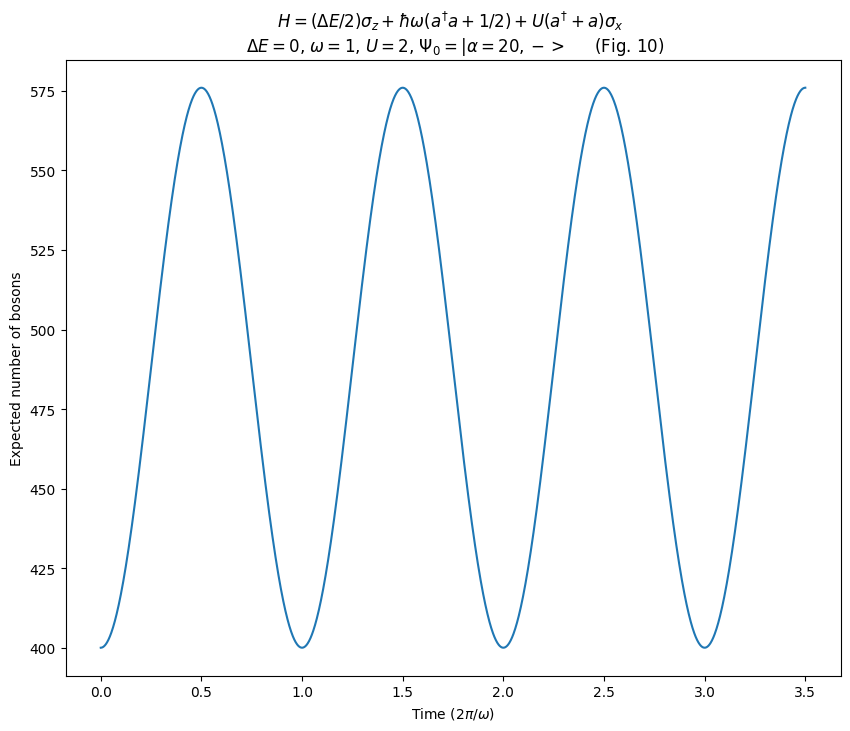

In [680]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi/omega), expected[0])
plt.ylabel("Expected number of bosons")
plt.xlabel("Time ($2\pi/\omega$)")
plt.title(f" {H_latex}   \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|\\alpha={alpha},->$     (Fig. 10)");
plt.show();

We can see in Fig. 10 that $\delta n \approx 175$, much larger than the 16 we had in the vacuum case. 

Let's check the energy conservation next.

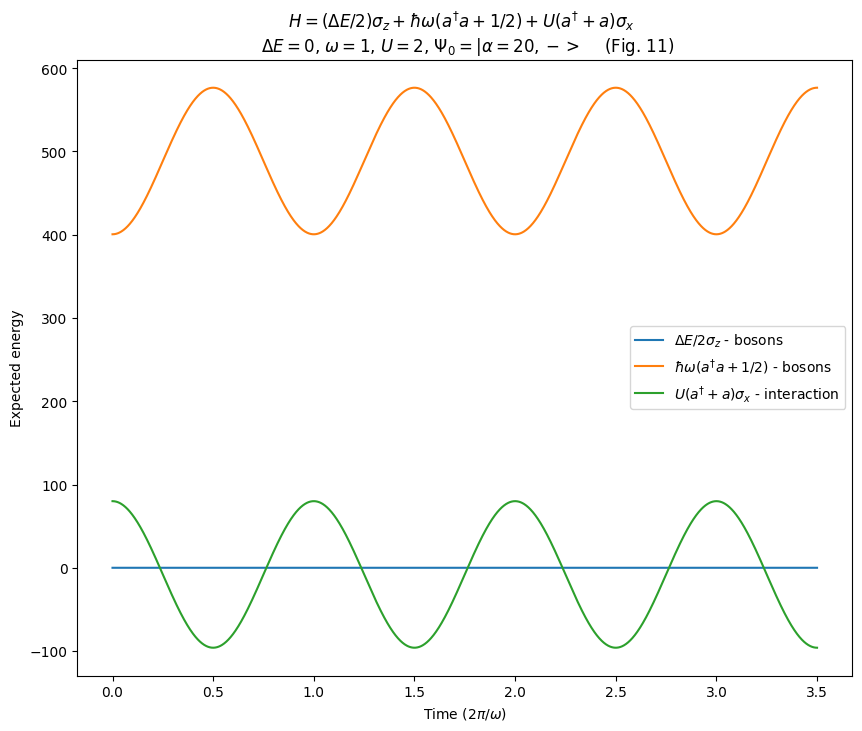

In [681]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi/omega), expected[3], label="$\Delta E/2 \sigma_z$ - bosons")
plt.plot(times/(2*np.pi/omega), expected[2], label="$\hbar\omega(a^{{\dagger}}a +1/2)$ - bosons")
plt.plot(times/(2*np.pi/omega), expected[1], label="$U( a^{{\dagger}} + a )\sigma_x$ - interaction")
plt.ylabel("Expected energy")
plt.xlabel("Time ($2\pi/\omega$)")
plt.title(f" {H_latex}   \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|\\alpha={alpha},->$    (Fig. 11)");
plt.legend(loc='right');
plt.show();

Fig. 11 confirms our picture that interaction is taking on an energy debt for the bosons, but now a much larger debt than in the vacuum case.

Let's now look at how the occupation probabilities for each state are changing over time. 

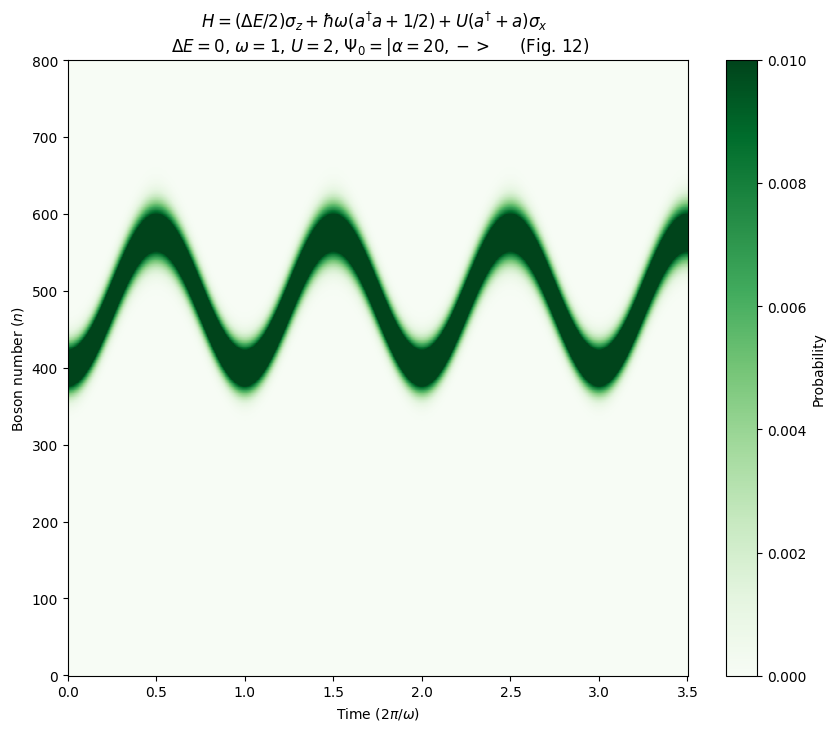

In [682]:
plt.figure(figsize=(10,8))
plt.pcolormesh(times/(2*np.pi/omega), np.arange(max_bosons+1), probs, shading='auto', cmap='Greens', vmax=0.01)
plt.colorbar(label="Probability")
plt.xlabel("Time ($2\pi/\omega$)")
plt.ylabel("Boson number ($n$)")
plt.title(f" {H_latex}   \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|\\alpha={alpha},->$     (Fig. 12)");

plt.show()

Fig. 12 is completely asymmetric compared to Fig. 9. The shape of Fig. 12 looks a lot more like the vacuum case in Fig. 5. We seem to have a Guassian pulse of creation and destruction oscillating on timescale given by the wave period. This is confirmed by looking at an animation of the dynamics below.

In [638]:
result = sesolve(H, psi0, times)

In [639]:
ani=animate_fock(result.states, times, xlabel="Boson number state",
                title=f"{H_latex}    (Fig. 13) \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|\\alpha={alpha},->$",
                xlim=[100,700],ylim=[0,0.04])

In [640]:
%%time
# Save the animation as a file
ani.save('./img/ani-fock-freex-02.mp4', writer='ffmpeg', fps=30)

CPU times: user 3min 33s, sys: 2.12 s, total: 3min 35s
Wall time: 1min 48s


In [641]:
Video("./img/ani-fock-freex-02.mp4") 

In [660]:
Video("./img/ani-fock-freex-dE10-minus-parity-negative.mp4")

We're now in a position to fully test our understanding of the deep strong coupling dynamics. In other words test out whether our model for the change in boson number works: 

$$
\delta n = 4\left(\frac{U}{\hbar \omega}\right)^2 + 4\frac{U}{\hbar \omega} \sqrt{n}
$$

For this, we'll calculate the maximum $\delta n$ for several values of  $\alpha = \sqrt{\langle n \rangle}$ and see how it compares with the model.

In [105]:
alphas = np.arange(0,21)

In [106]:
dn_model = 4*U**2 + 4*U*np.sqrt(alphas**2)

In [107]:
dn_simulate = []
for a in alphas:
    psi0 = coherent(max_bosons+1, a)
    result = sesolve(H, psi0, times, e_ops = [number])
    dn = np.max(result.expect[0] - result.expect[0][0])
    dn_simulate.append(dn)

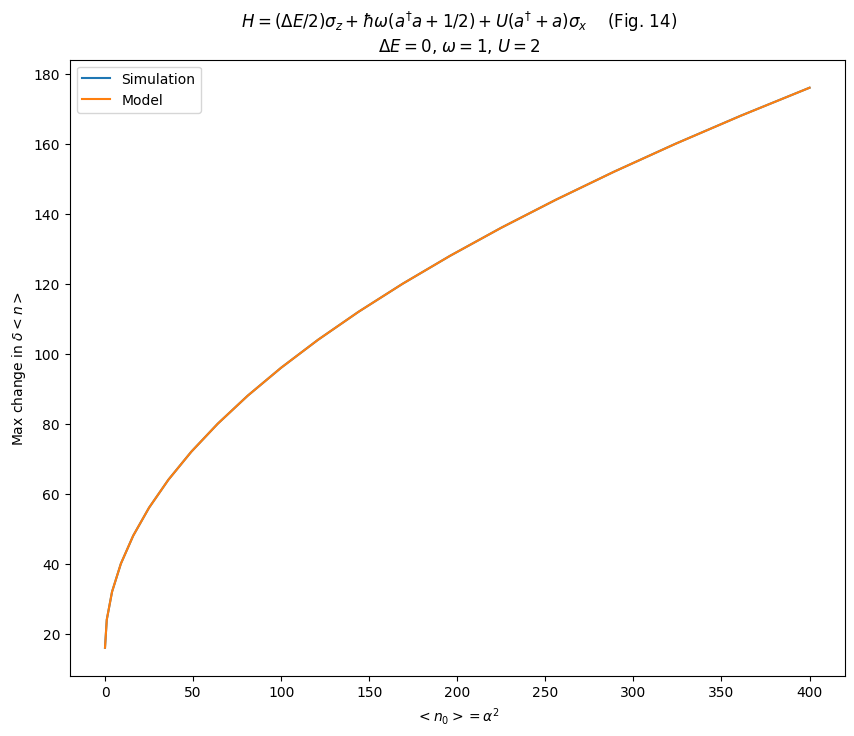

In [108]:
plt.figure(figsize=(10,8))
plt.plot(alphas*alphas, dn_simulate, label="Simulation")
plt.plot(alphas*alphas,  dn_model, label="Model")
plt.title(f" {H_latex}    (Fig. 14) \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$ ");
plt.legend()
plt.ylabel("Max change in $\\delta <n>$")
plt.xlabel("$<n_0>=\\alpha^2$");

Astonishingly, Fig. 14 shows that we have a perfect fit between our model and the simulations 🤩 !

We can say for sure now that the more highly excited the field, the more bosons can get spontaneously created and destroyed.

### Coherent emission rates

All quantum system eventually have to interact with their environment. For deep strong coupled systems, if "measurement" happens on a timescale shorter than the half a wave period, then we'd observe more bosons than when we started with. The longer we wait, the more bosons there would be. We can construct a "coherent emission rate" based on this idea.

For large $n$, the maximum number of bosons created is $4U\sqrt{n}/\hbar\omega$ and the time over which this maximum occurs is half a wave period $T/2$. We can therefore calculate an approximate average "coherent emission rate" as:

$$
\begin{aligned}
\gamma_{\rm coherent} &= \frac{4U\sqrt{n}}{\hbar\omega} \frac{1}{T/2} \\
&= \frac{4U\sqrt{n}}{\hbar\omega} \frac{2}{T} \\
&= \frac{4U\sqrt{n}}{\hbar\omega} \frac{\omega}{\pi}  \\
&= \frac{4}{\pi}\frac{U\sqrt{n}}{\hbar} \\
\end{aligned}
$$

What's very interesting about this rate is the appearance of $2U\sqrt{n}/\hbar$. This is an expression for the [Rabi frequency](https://en.wikipedia.org/wiki/Vacuum_Rabi_oscillation) of an oscillation between the states of a TLS when the field is not in vacuum. 

The significance of this frequency lies in remembering that changing state in the Rabi model means flipping the TLS and changing the boson number by one (due to the parity conservation). In other words, in each Rabi period we get an extra boson. We should therefore expect to be able to construct the coherent emission rate $\gamma_{\rm coherent}$ by saying that 1 boson is created in half a Rabi period ($T_{\rm Rabi}$), in other words:

$$
\begin{aligned}
\gamma_{\rm coherent} &= \frac{1}{T_{\rm Rabi}/2} \\
&= \frac{2}{2\pi/\Omega} \\
&= \frac{\Omega}{\pi} \\
&= \frac{2}{\pi}\frac{U\sqrt{n}}{\hbar} \\
\end{aligned}
$$

The two results are the same (to within a factor of 2) 🙌.

Whether or not we can make use of this coherent emission is yet to be seen. If our Rabi system was coupled to another oscillator with a higher frequency, perhaps the deep strong coupling could allow a many to one exchange of quanta. We've still got a little way to go before we can simulate that though.

### Next up...

We've seen that energy flows between quantum states more freely in a deep strong coupled system compared to the strongly coupled systems we've looked at so far in this series. We are no longer limited by strict resonance requirements.

The big question is, does this hold up when there is a "price to pay" for flipping the TLS from $-$ to $+$. In other words, what happens when we relax the degeneracy constraint $\Delta E = 0$. 

See you for the next one when we answer that question.

👋

---
## Appendix - Coupled pendulum code

We use the small angle approximation and assume that the vertical position of each pendulum is the same when they are in equilibrium. The spring coupling is described by constant $k$ and is proportional to the angular differences in the coupled pendulums. The friction for the green pendulum is described by constant $b$ and is proportional to its angular speed. 

\begin{align}
\ddot{\theta}_B &= - \omega_0^2 \theta_B + k \left( 2 \theta_B - \theta_R \frac{\omega_0^2}{\omega_R^2} - \theta_G \frac{\omega_0^2}{\omega_G^2} \right) \\
\ddot{\theta}_O &= - \omega_0^2 \theta_O + k \left( 2 \theta_O - \theta_R \frac{\omega_0^2}{\omega_R^2} - \theta_G \frac{\omega_0^2}{\omega_G^2} \right) \\
\ddot{\theta}_R &= - \omega_R^2 \theta_R + k \left( 2 \theta_R - \theta_O \frac{\omega_R^2}{\omega_0^2} - \theta_B \frac{\omega_R^2}{\omega_0^2} \right) \\
\ddot{\theta}_G &= - \omega_G^2 \theta_G + k \left( 2 \theta_G - \theta_O \frac{\omega_G^2}{\omega_0^2} - \theta_B \frac{\omega_G^2}{\omega_0^2} \right) - b\dot{\theta}_G
\end{align}


In [218]:
# Configuration parameters for two coupled pendulums
g = 9.8

l_A = 5  # Length for pendulum A
l_B = 5  # Length for pendulum B

w_B = np.sqrt(g/l_A)  # Natural frequency for pendulum A 
w_A = np.sqrt(g/l_B)  # Natural frequency for pendulum B

k = 0.1  # Coupling constant
b_A, b_B = 0.5, 0.5 #  damping coefficients

# Initial conditions
theta_A0 = -0.5  # Initial amplitude for pendulum A
omega_A0 = 0.0  # Initial angular velocity for pendulum A
theta_B0 = 0.0  # Initial amplitude for pendulum B
omega_B0 = 0.0  # Initial angular velocity for pendulum B

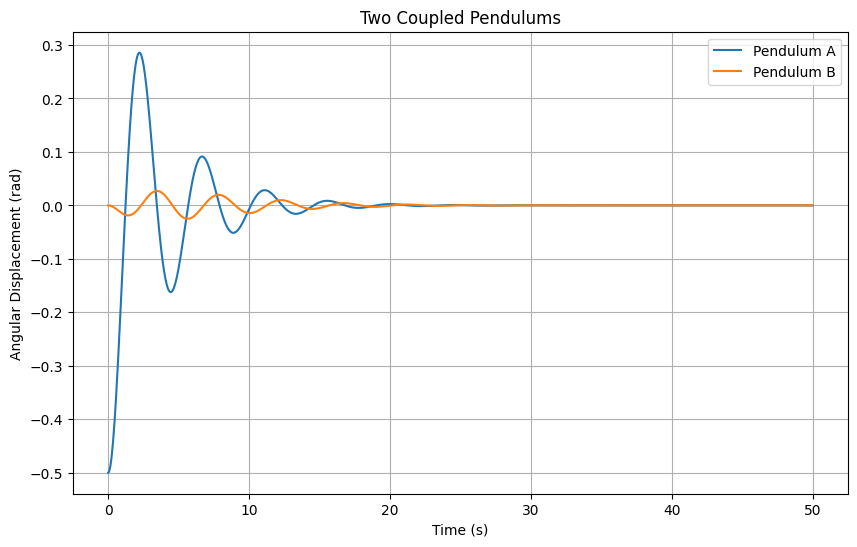

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the system of ODEs
def equations(t, y):
    theta_A, omega_A, theta_B, omega_B = y
    
    dtheta_A = omega_A
    domega_A = -(w_A**2 + k) * theta_A - b_A * omega_A + k * theta_B
    
    dtheta_B = omega_B
    domega_B = -(w_B**2 + k) * theta_B - b_B * omega_B + k * theta_A
    
    return [dtheta_A, domega_A, dtheta_B, domega_B]

# Bundle initial conditions
initial_conditions = [theta_A0, omega_A0, theta_B0, omega_B0]

# Time span for the simulation
t_span = (0, 50)  # Reduced time span for clearer visualization
t_eval = np.linspace(*t_span, 1000)  # Time points for solution

# Solve the system of ODEs
solution = solve_ivp(equations, t_span, initial_conditions, t_eval=t_eval, method='RK45')

# Extract solutions
theta_A_sol = solution.y[0]
theta_B_sol = solution.y[2]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_eval, theta_A_sol, label='Pendulum A')
plt.plot(t_eval, theta_B_sol, label='Pendulum B')
plt.xlabel('Time (s)')
plt.ylabel('Angular Displacement (rad)')
plt.title('Two Coupled Pendulums')
plt.legend()
plt.grid(True)
plt.savefig('two_pendulums.png')

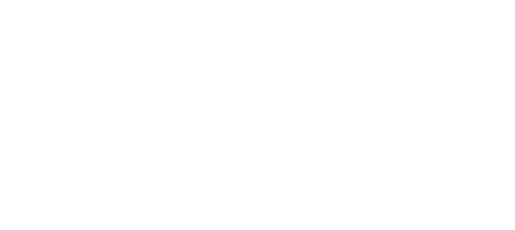

In [220]:
# Parameters
plane_angle_deg = -0  # Inclined plane angle in degrees
plane_angle = np.radians(plane_angle_deg)
offset_A = -5  # Horizontal offset for pendulum A
offset_B = 5   # Horizontal offset for pendulum B
bob_target_y = -max(l_A, l_B)  # Align bobs at this y-coordinate when at rest

# Define pivot points on the inclined plane
y_pivot_A = offset_A * np.tan(plane_angle)  # Vertical offset for pendulum A's pivot
y_pivot_B = offset_B * np.tan(plane_angle)  # Vertical offset for pendulum B's pivot

# Convert angular displacements to Cartesian coordinates
x_A = offset_A + l_A * np.sin(theta_A_sol)
y_A = y_pivot_A - l_A * np.cos(theta_A_sol)
x_B = offset_B + l_B * np.sin(theta_B_sol)
y_B = y_pivot_B - l_B * np.cos(theta_B_sol)

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(min(x_A) - 2, max(x_B)+2)
# ax.set_ylim(min(y_pivot_B - l_B -1, y_pivot_B-l_A-1), max(y_pivot_A + 1, y_pivot_B + 1))  # Adjust for plane and swings
ax.set_ylim(min(min(y_A),min(y_B)-1), (max(y_pivot_A,y_pivot_B)+1))
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)

# (Optional) Remove box frame (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Create lines for pendulums, bobs, coupling, and inclined plane
line_AB, = ax.plot([], [], color='blue', lw=1)  # Line connecting A to B
line_A, = ax.plot([], [], '-', lw=2, color='green', label='Pendulum A')
bob_A, = ax.plot([], [], 'ro', markersize=13)  # Red bob for pendulum A
line_B, = ax.plot([], [], '-', lw=2, color='green', label='Pendulum B')
bob_B, = ax.plot([], [], 'ro', markersize=13)  # Red bob for pendulum B
line_plane, = ax.plot([], [], 'k-', lw=2)  # Inclined plane

# Initialize the animation
def init():
    line_AB.set_data([], [])
    line_A.set_data([], [])
    bob_A.set_data([], [])
    line_B.set_data([], [])
    bob_B.set_data([], [])
    line_plane.set_data([], [])
    return line_A, bob_A, line_B, bob_B, line_AB, line_plane

# Update function for the animation
def update(frame):
    line_AB.set_data([x_A[frame], x_B[frame]], [y_A[frame], y_B[frame]])
    line_A.set_data([offset_A, x_A[frame]], [y_pivot_A, y_A[frame]])
    bob_A.set_data([x_A[frame]], [y_A[frame]])
    line_B.set_data([offset_B, x_B[frame]], [y_pivot_B, y_B[frame]])
    bob_B.set_data([x_B[frame]], [y_B[frame]])
    plane_x = [-6, 6]  # Extend plane beyond pivots
    plane_y = [x * np.tan(plane_angle) for x in plane_x]
    line_plane.set_data(plane_x, plane_y)
    return line_A, bob_A, line_B, bob_B, line_AB, line_plane

# Create the animation
ani = FuncAnimation(fig, update, frames=len(t_eval), init_func=init, blit=False, interval=40)

# Save the animation as a file
ani.save('two_pendulums_animation_different_lengths.mp4', writer='ffmpeg', fps=30)

In [222]:
from IPython.display import Video
Video("two_pendulums_animation_different_lengths.mp4")